# Metadynamics 分析

## Load Environment

First, load necessary modules to be load in the following steps.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Load Hills

We could load hills from `HILLS` produced by Plumed, to do more analysis. 
Here, we just use the examples provided by V. Spiwok, 
which is trajectories of Alanine Dipeptide in water with 1, 2 or 3 Ramachandran angles, respectively.

In [2]:
from miko.metad.hills import Hills

In [3]:
#load hills
h1 = Hills(name="../../tests/metad/data/hills/acealanme1d", periodic=[True], cv_per=[[-np.pi, np.pi]])
h2 = Hills(name="../../tests/metad/data/hills/acealanme", periodic=[True,True], cv_per=[[-np.pi, np.pi], [-np.pi, np.pi]])
h3 = Hills(name="../../tests/metad/data/hills/acealanme3d", periodic=[True,True,True], cv_per=[[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]])

## Sum Hills using `Fes`

We could just use `metadynminer.fes` to sum the hills to get the Free Energy Surface (FES).

For example, here we just use the fast approach to draw the FES of `acealanme` (with 2 CVs).

In [4]:
from miko.metad.fes import FreeEnergySurface

# do sum_hills
fes = FreeEnergySurface.from_hills(h2, resolution=256)

For here, there are two approaches. One is the `fast` approach, quickly do the sum in lack of accuracy.
The other is the `original` approach, just do the same as `plumed sum_hills` command.
Here, we use the original method with 4 workers to accelerate the build of FES.

(<Figure size 960x672 with 2 Axes>,
 <Axes: xlabel='CV1 - phi', ylabel='CV2 - psi'>)

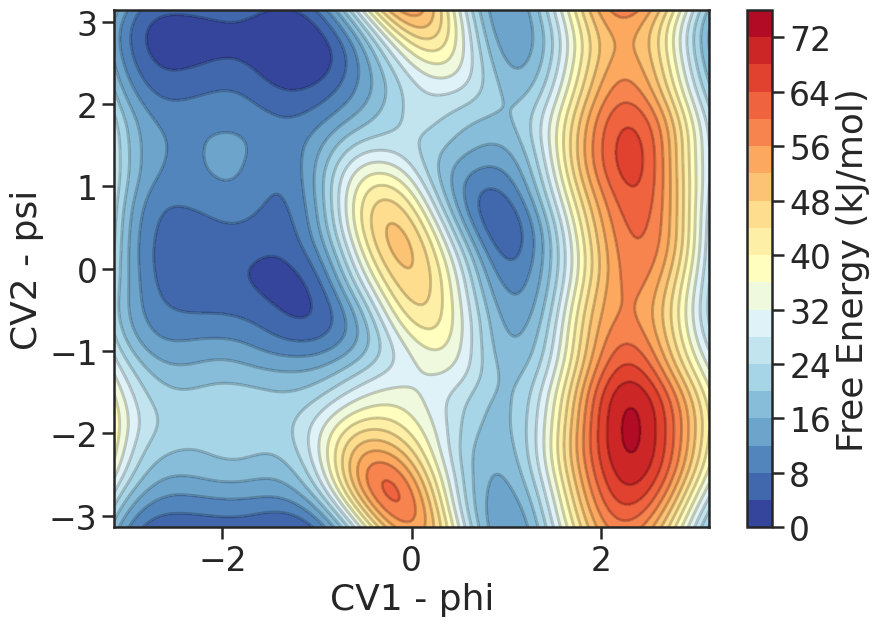

In [5]:
fes.make_fes_original(resolution=256, n_workers=4)
# plot the FES
fes.plot(cmap="RdYlBu_r", levels=20, dpi=96, style='ticks', context='talk')

## Remove CVs
You could use `fes.remove_cv(cv_index)` or `fes.remove_cvs([cv_index_0, cv_index_1])` to remove CV(s) from the built FES, to plot the relationship between one or two CVs and free energy surface.

In [6]:
# do sum_hills
fes2 = fes.remove_cvs([1])

2023-07-13 20:42:43,105 - INFO : Removing CV 1.


(<Figure size 960x672 with 1 Axes>,
 <Axes: xlabel='CV1 - phi', ylabel='Free Energy (kJ/mol)'>)

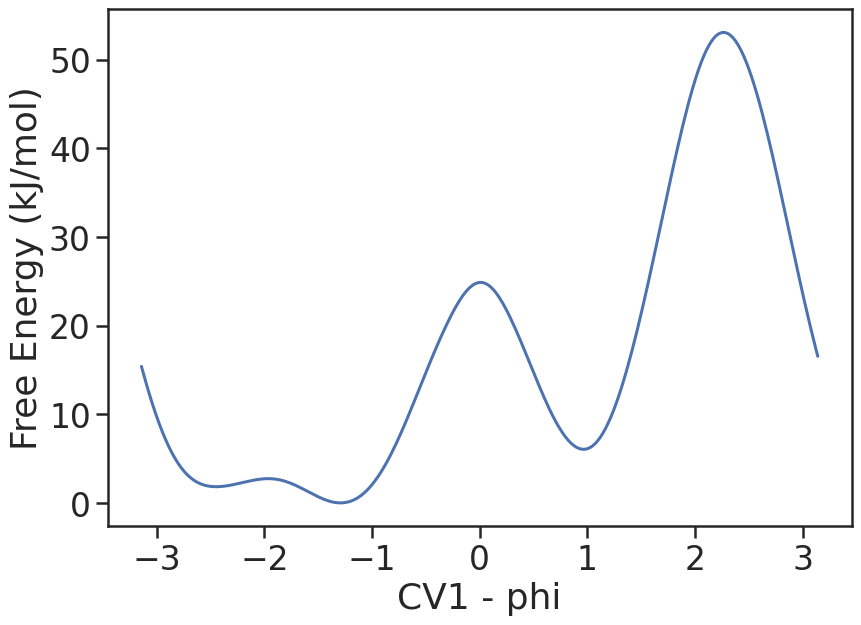

In [7]:
# plot the FES
fes2.plot(cmap="RdYlBu", levels=20, dpi=96, style='ticks', context='talk')

Compared with FES from `h1`, we could see similar trend.

In [8]:
# do sum_hills
fes_1d = FreeEnergySurface.from_hills(h1, resolution=256)

(<Figure size 960x672 with 1 Axes>,
 <Axes: xlabel='CV1 - phi', ylabel='Free Energy (kJ/mol)'>)

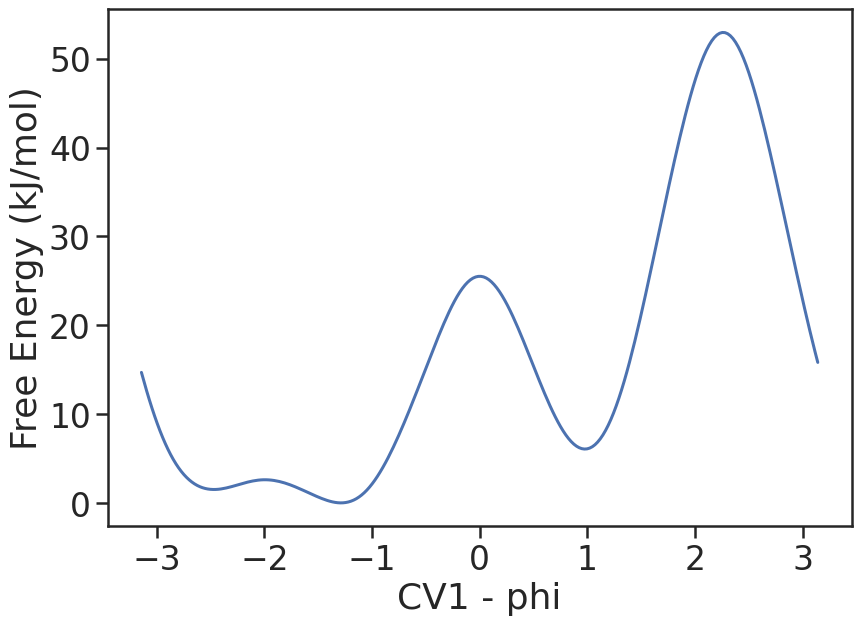

In [9]:
fes_1d.make_fes_original(resolution=256, n_workers=4)
# plot the FES
fes_1d.plot(cmap="RdYlBu", levels=20, dpi=96, style='ticks', context='talk')

### Find local minima

We could then use `fes.find_minima` to analyze the FES acquired, and to label them in the plot.

(<Figure size 960x672 with 2 Axes>,
 <Axes: xlabel='CV1 - phi', ylabel='CV2 - psi'>)

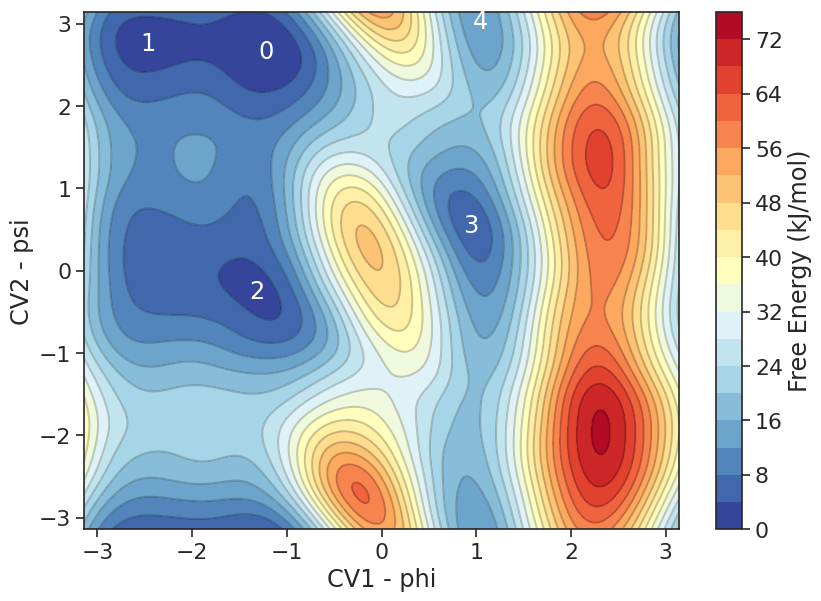

In [10]:
fes.find_minima()

# plot the minimas
fes.plot_minima(mark_color="white", png_name=None, style='ticks', context='notebook')

Local minima are stored in `pandas.DataFrame`, as shown in below.

In [11]:
fes.minima

,Minimum,free energy,CV1bin,CV2bin,CV1 - phi,CV2 - psi
0,0,0.000000,78.0,236.0,-1.214913,2.662991
1,1,1.635963,27.0,240.0,-2.466641,2.761165
2,2,2.670061,74.0,117.0,-1.313088,-0.257709
3,3,5.255746,166.0,150.0,0.944932,0.552233
4,4,12.537359,170.0,251.0,1.043107,3.031146


## Free Energy Time-dependent Profile

We could draw the time-dependent profile of free energies of local minima from `FEProfile`.

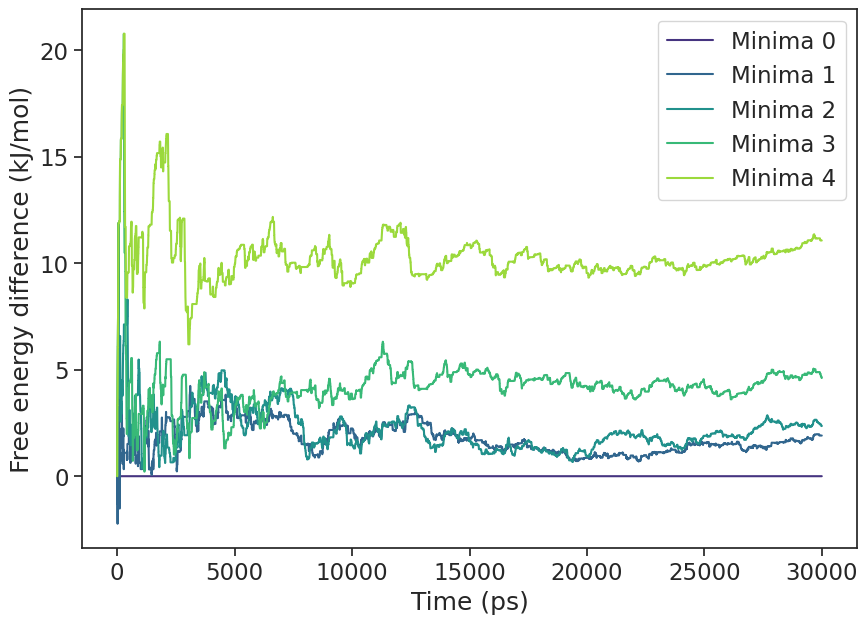

In [13]:
from miko.metad.profile import FreeEnergyProfile
fe_profile = FreeEnergyProfile(fes, h2)
fe_profile.plot(energy_unit="kJ/mol", cmap="viridis", style='ticks', context='notebook')

# Using String Method to Find Minimal Energy Path (MEP)

We could use string method to find MEP on the plotted FEP.

> Reference: Weinan E, et al. "Simplified and improved string method for computing the minimum energy paths in barrier-crossing events", J. Chem. Phys. 126, 164103 (2007), https://doi.org/10.1063/1.2720838

In [14]:
from miko.metad.string import StringMethod
s = StringMethod(fes)

Load the minima from the upper block.

In [15]:
s.load_minima()

2023-07-13 20:45:26,924 - INFO :    Minimum  free energy  CV1bin  CV2bin  CV1 - phi  CV2 - psi
0        0     0.000000    78.0   236.0  -1.214913   2.662991
1        1     1.635963    27.0   240.0  -2.466641   2.761165
2        2     2.670061    74.0   117.0  -1.313088  -0.257709
3        3     5.255746   166.0   150.0   0.944932   0.552233
4        4    12.537359   170.0   251.0   1.043107   3.031146


We just try the path from Minima 1 to 2, crossing 0.

In [16]:
s.mep_from_minima(begin_index=1, end_index=2, mid_indices = [0])

100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


After 100 iteration, the string converged. We could plot its evolution:

(<Figure size 960x672 with 2 Axes>,
 <Axes: xlabel='CV1 - phi', ylabel='CV2 - psi'>)

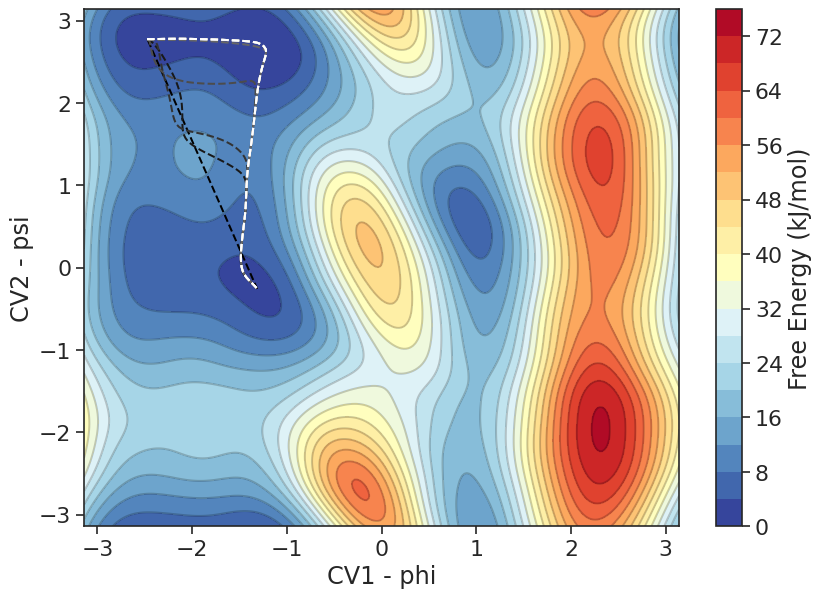

In [17]:
s.plot_string_evolution(cmap="RdYlBu_r", levels=20, dpi=96)

And draw the final MEP on the plot:

(<Figure size 960x672 with 2 Axes>,
 <Axes: xlabel='CV1 - phi', ylabel='CV2 - psi'>)

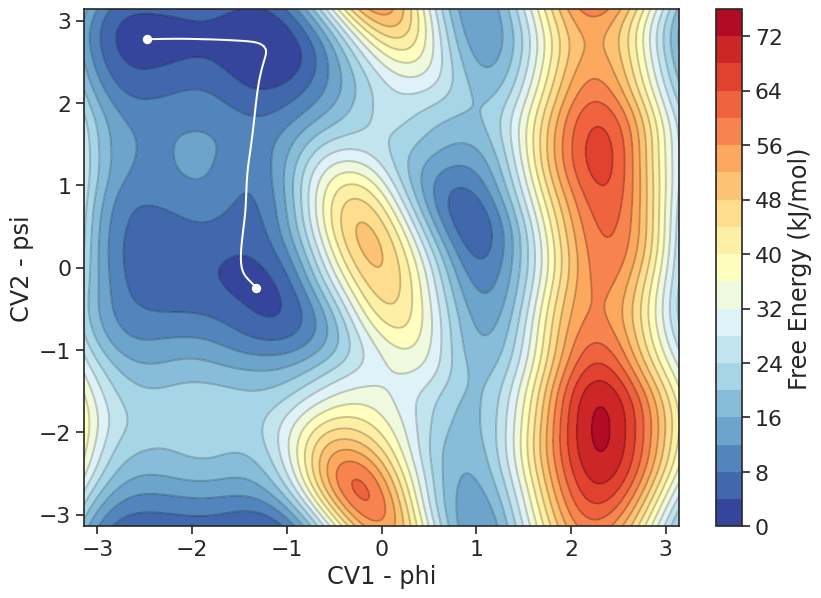

In [18]:
s.plot_mep(cmap="RdYlBu_r", levels=20, dpi=96)

Last but not least, the free energy profile of the MEP:

(<Figure size 614.4x460.8 with 1 Axes>,
 <Axes: xlabel='Reaction coordinate', ylabel='Free Energy (kJ/mol)'>)

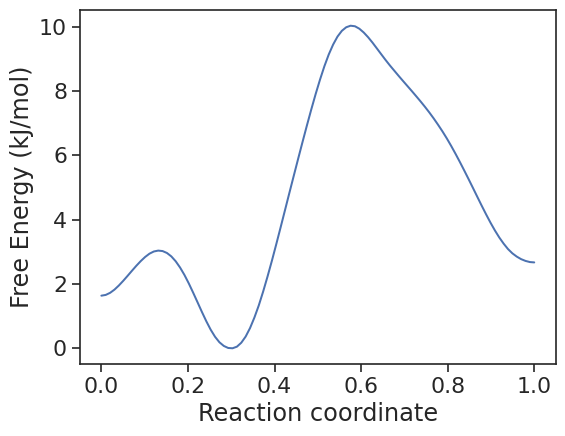

In [19]:
s.plot_mep_energy_profile(dpi=96)